In [176]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sn
import pandas as pd
import pickle
from collections import defaultdict
from sklearn import metrics

In [165]:
class GTZANDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx][0]
        y = self.data[idx][1]
        
        if self.transform:
            x = self.transform(x)
        
        x = torch.Tensor(x)

        return (x, y)

In [154]:
batch_size = 1


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

GTZAN_data = pickle.load(open('data/GTZAN.train', 'rb'))
trainset = GTZANDataset(GTZAN_data)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

GTZAN_data = pickle.load(open('data/GTZAN.test', 'rb'))
testset = GTZANDataset(GTZAN_data)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)


classes = ('blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock')

In [132]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cpu


In [133]:
class Net(nn.Module):  
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(20*32*161, 100) # Get the vector of the layer right before the final fc layer and plot tfidf
        self.fc2 = nn.Linear(100, 10) 
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 20*32*161)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

class Net(nn.Module):  
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(20*32*161, 100) # Get the vector of the layer right before the final fc layer and plot tfidf
        self.fc2 = nn.Linear(100, 10) 
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 20*32*161)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=103040, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

In [ ]:
net = Net()     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

In [134]:
# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  
# We use stochastic gradient descent (SGD) as optimizer.
opt = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) 

In [135]:
avg_losses = []   # Avg. losses.
epochs = 5       # Total epochs.
print_freq = 100  # Print frequency.

try:
    for epoch in range(epochs):  # Loop over the dataset multiple times.
        running_loss = 0.0       # Initialize running loss.
        for i, data in enumerate(trainloader, 0):

            # Get the inputs.
            inputs, labels = data

            # Move the inputs to the specified device.
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients.
            opt.zero_grad()

            # Forward step.
            outputs = net(inputs)
            loss = loss_func(outputs, labels)

            # Backward step.
            loss.backward()

            # Optimization step (update the parameters).
            opt.step()

            # Print statistics.
            running_loss += loss.item()
            if i % print_freq == print_freq - 1: # Print every several mini-batches.
                avg_loss = running_loss / print_freq
                print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                    epoch, i, avg_loss))
                avg_losses.append(avg_loss)
                running_loss = 0.0

    print('Finished Training.')
except KeyboardInterrupt:
    print('Halted Training')

[epoch: 0, i:    99] avg mini-batch loss: 3.519
[epoch: 0, i:   199] avg mini-batch loss: 2.307
[epoch: 0, i:   299] avg mini-batch loss: 2.309
[epoch: 0, i:   399] avg mini-batch loss: 2.308
[epoch: 0, i:   499] avg mini-batch loss: 2.307
[epoch: 0, i:   599] avg mini-batch loss: 2.302
[epoch: 0, i:   699] avg mini-batch loss: 2.308
[epoch: 0, i:   799] avg mini-batch loss: 2.302
[epoch: 1, i:    99] avg mini-batch loss: 2.305
[epoch: 1, i:   199] avg mini-batch loss: 2.299
[epoch: 1, i:   299] avg mini-batch loss: 2.306
[epoch: 1, i:   399] avg mini-batch loss: 2.297
[epoch: 1, i:   499] avg mini-batch loss: 2.317
[epoch: 1, i:   599] avg mini-batch loss: 2.310
[epoch: 1, i:   699] avg mini-batch loss: 2.306
[epoch: 1, i:   799] avg mini-batch loss: 2.302
[epoch: 2, i:    99] avg mini-batch loss: 2.307
[epoch: 2, i:   199] avg mini-batch loss: 2.307
[epoch: 2, i:   299] avg mini-batch loss: 2.305
[epoch: 2, i:   399] avg mini-batch loss: 2.305
[epoch: 2, i:   499] avg mini-batch loss

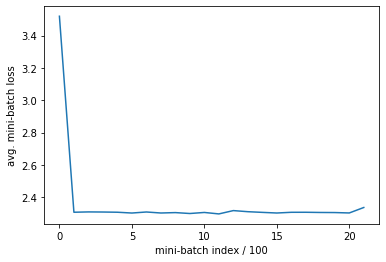

In [139]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

In [140]:
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 6 %


In [172]:
preds = []
truths = []

# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        if type(c) is not list:
            c = [c]
        for i in range(batch_size):
            preds.append(predicted[i].item())
            truths.append(labels[i].item())
            confusion_matrix[actual][pred] += 1
            
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of blues :  0 %
Accuracy of classical : 100 %
Accuracy of country :  0 %
Accuracy of disco :  0 %
Accuracy of hiphop :  0 %
Accuracy of  jazz :  0 %
Accuracy of metal :  0 %
Accuracy of   pop :  0 %
Accuracy of reggae :  0 %
Accuracy of  rock :  0 %


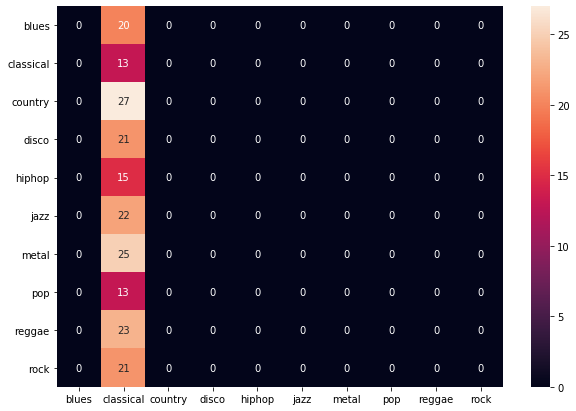

In [178]:
array = metrics.confusion_matrix(truths, preds)
df_cm = pd.DataFrame(array, index = classes, columns = classes)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)